In [1]:
# ==============================================================
# Gaussian Naive Bayes (GNB) Experiment
# ==============================================================
import pandas as pd
import numpy as np
import sys
import time
from datetime import datetime

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import prepare_data

# Experiment config
random_state = 42
results = []
partial_save_path = "results/naive_bayes_partial.csv"

In [2]:
# ---
# 1. Load Data
# ---
train_df = pd.read_csv("fraudTrain.csv")
test_df = pd.read_csv("fraudTest.csv")

print("Loaded train/test data.")

Loaded train/test data.


In [3]:
# ---
# 2. Prepare Data for LINEAR Models
# ---
# We MUST use mode="linear". This applies StandardScaler and OneHotEncoder.
# We fit ONCE on the training data.
print("Fitting encoders and scalers on train data...")
out_train_init = prepare_data(
    train_df,
    mode="linear",
    training=False,  # We only need the encoders/scalers
    fit=True,
)
encoders = out_train_init["encoders"]
scalers = out_train_init["scalers"] # <-- GNB needs this
print("Fit complete.")

# Prepare TEST set using the *same* "linear" mode and fitted objects
print("Preparing test set...")
out_test = prepare_data(
    test_df,
    mode="linear",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers,
)
df_test = out_test["df"]
X_test = df_test.drop("is_fraud", axis=1)
y_test = df_test["is_fraud"]

# Clean inf/-inf values (just in case)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

print(f"Test set prepared for linear models. Shape: {X_test.shape}")

Fitting encoders and scalers on train data...
Fit complete.
Preparing test set...
Test set prepared for linear models. Shape: (555719, 25)


In [4]:
# ---
# 3. Define Experiment Parameters
# ---
# We will test all ratios for this baseline model
ratios_to_test = [None, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0] 
resample_types_to_test = ["df_up", "df_down"] 

# GaussianNB has no real hyperparameters to tune here
params_to_test = [
    {
        "name": "GaussianNB",
        "params": {}, # No parameters needed
    }
]

In [5]:
# ---
# 4. Run Experiment Loop
# ---
print("\nStarting Gaussian Naive Bayes experiment loop...")
for ratio_idx, ratio in enumerate(ratios_to_test, start=1):
    print(f"\n{'='*70}")
    print(
        f"[{datetime.now().strftime('%H:%M:%S')}] Starting ratio {ratio_idx}/{len(ratios_to_test)} → ratio={ratio}"
    )
    start_ratio_time = time.time()

    # Prepare training data for this *specific ratio*
    # We use fit=False (THE CORRECT WAY)
    out_train = prepare_data(
        train_df,
        mode="linear",
        training=True,
        ratio=ratio,
        fit=False,  
        encoders=encoders,
        scalers=scalers,
    )

    for resample_type in resample_types_to_test:
        if resample_type not in out_train or out_train[resample_type] is None:
            continue

        df_train = out_train[resample_type]
        X_train = df_train.drop("is_fraud", axis=1)
        y_train = df_train["is_fraud"]

        # Clean inf/-inf values
        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

        print(
            f"  [{datetime.now().strftime('%H:%M:%S')}] → Training on {resample_type} (samples={len(X_train):,})"
        )
        sys.stdout.flush()

        for p_info in params_to_test:
            model_name = p_info["name"]
            params = p_info["params"]
            start_k_time = time.time()

            print(f"    ⏳ Running {model_name} ...", end="")
            sys.stdout.flush()

            model = GaussianNB(**params)
            
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]

            # Metrics
            f1 = f1_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_prob)
            prec = precision_score(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
            
            results.append(
                {
                    "model": model_name,
                    "ratio": ratio,
                    "resample_type": resample_type.replace("df_",""),
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec,
                    "f1": f1,
                    "roc_auc": auc,
                }
            )

            print(
                f" done → F1={f1:.4f}, Recall={rec:.4f}, AUC={auc:.4f} | Time={time.time() - start_k_time:.1f}s"
            )
            sys.stdout.flush()

    pd.DataFrame(results).to_csv(partial_save_path, index=False)
    print(f"  💾 Saved intermediate results → {partial_save_path}")
    print(f"  ✅ Completed ratio={ratio} in {(time.time() - start_ratio_time)/60:.1f} min")


Starting Gaussian Naive Bayes experiment loop...

[19:49:36] Starting ratio 1/7 → ratio=None
  [19:49:41] → Training on df_up (samples=1,296,675)
    ⏳ Running GaussianNB ... done → F1=0.0354, Recall=0.6853, AUC=0.7902 | Time=2.1s
  [19:49:45] → Training on df_down (samples=1,296,675)
    ⏳ Running GaussianNB ... done → F1=0.0354, Recall=0.6853, AUC=0.7902 | Time=1.8s
  💾 Saved intermediate results → results/naive_bayes_partial.csv
  ✅ Completed ratio=None in 0.2 min

[19:49:47] Starting ratio 2/7 → ratio=0.05
  [19:49:51] → Training on df_up (samples=1,353,627)
    ⏳ Running GaussianNB ... done → F1=0.0225, Recall=0.7133, AUC=0.7893 | Time=1.6s
  [19:49:53] → Training on df_down (samples=157,626)
    ⏳ Running GaussianNB ... done → F1=0.0224, Recall=0.7133, AUC=0.7909 | Time=0.7s
  💾 Saved intermediate results → results/naive_bayes_partial.csv
  ✅ Completed ratio=0.05 in 0.1 min

[19:49:54] Starting ratio 3/7 → ratio=0.1
  [19:49:59] → Training on df_up (samples=1,418,086)
    ⏳ Runn

In [6]:
# ---
# 5. Show Final Results
# ---
print("\nAll ratios completed.")
print(f"Total experiments logged: {len(results)}")
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
print("\n--- Top Performing Naive Bayes Models ---")
print(results_df.head(10))

results_df.to_csv("results/naive_bayes_results.csv", index=False)
print("\nSaved final results to results/naive_bayes_results.csv")


All ratios completed.
Total experiments logged: 14

--- Top Performing Naive Bayes Models ---
        model  ratio resample_type  accuracy  precision    recall        f1  \
0  GaussianNB    NaN            up  0.855801   0.018164  0.685315  0.035390   
1  GaussianNB    NaN          down  0.855801   0.018164  0.685315  0.035390   
2  GaussianNB   0.05            up  0.760282   0.011407  0.713287  0.022454   
3  GaussianNB   0.05          down  0.759970   0.011392  0.713287  0.022426   
4  GaussianNB   0.10            up  0.747955   0.010853  0.713287  0.021380   
5  GaussianNB   0.10          down  0.747405   0.010829  0.713287  0.021334   
7  GaussianNB   0.20          down  0.716421   0.009653  0.713287  0.019048   
6  GaussianNB   0.20            up  0.715586   0.009625  0.713287  0.018993   
8  GaussianNB   0.30            up  0.680236   0.008566  0.713287  0.016929   
9  GaussianNB   0.30          down  0.676111   0.008457  0.713287  0.016717   

    roc_auc  
0  0.790161  
1  0.79


Generating plots...


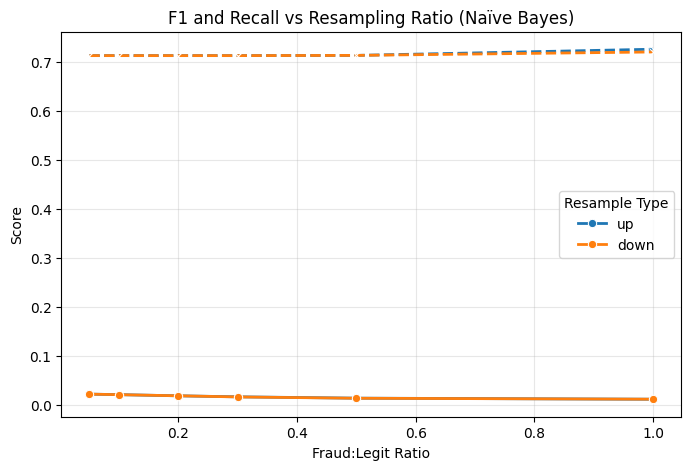

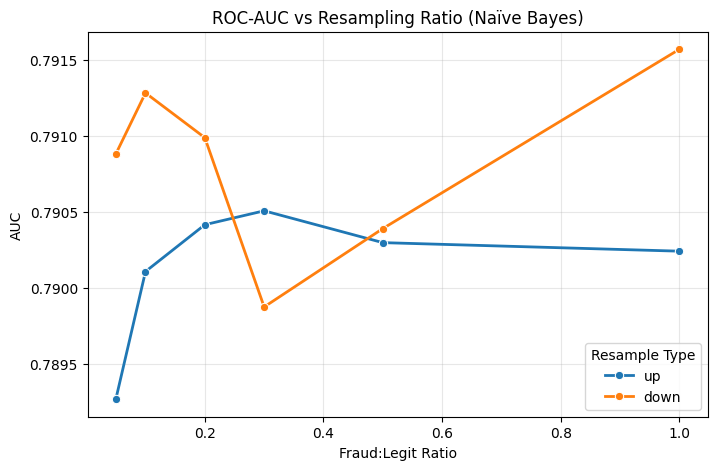


--- Mean Scores Summary ---
                     precision  recall     f1  roc_auc
ratio resample_type                                   
0.05  down               0.011   0.713  0.022    0.791
      up                 0.011   0.713  0.022    0.789
0.10  down               0.011   0.713  0.021    0.791
      up                 0.011   0.713  0.021    0.790
0.20  down               0.010   0.713  0.019    0.791
      up                 0.010   0.713  0.019    0.790
0.30  down               0.008   0.713  0.017    0.790
      up                 0.009   0.713  0.017    0.791
0.50  down               0.007   0.714  0.014    0.790
      up                 0.007   0.714  0.014    0.790
1.00  down               0.006   0.721  0.012    0.792
      up                 0.006   0.726  0.012    0.790

Plots and summary complete.


In [7]:
# ---
# 6. Plot Results
# ---
if not results_df.empty:
    print("\nGenerating plots...")
    
    # ---- Plot F1 & Recall vs Ratio ----
    plt.figure(figsize=(8,5))
    sns.lineplot(data=results_df, x="ratio", y="f1", hue="resample_type", marker="o", linewidth=2)
    sns.lineplot(data=results_df, x="ratio", y="recall", hue="resample_type", marker="x", linestyle="--", linewidth=2, legend=False)
    plt.title("F1 and Recall vs Resampling Ratio (Naïve Bayes)")
    plt.xlabel("Fraud:Legit Ratio")
    plt.ylabel("Score")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Resample Type")
    plt.savefig("results/naive_bayes_f1_recall_plot.png")
    plt.show()

    # ---- Plot ROC-AUC vs Ratio ----
    plt.figure(figsize=(8,5))
    sns.lineplot(data=results_df, x="ratio", y="roc_auc", hue="resample_type", marker="o", linewidth=2)
    plt.title("ROC-AUC vs Resampling Ratio (Naïve Bayes)")
    plt.xlabel("Fraud:Legit Ratio")
    plt.ylabel("AUC")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Resample Type")
    plt.savefig("results/naive_bayes_auc_plot.png")
    plt.show()
    
    # ---- Summary Table ----
    summary = results_df.groupby(["ratio", "resample_type"])[["precision", "recall", "f1", "roc_auc"]].mean().round(3)
    print("\n--- Mean Scores Summary ---")
    print(summary)

    print("\nPlots and summary complete.")
else:
    print("No results to plot.")